Importando bibliotecas

In [2]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt


folder_dir = '..\\flowers'

SIZE = 128 # Cropa a imagem em 128x128

Cropando e carregando as imagens

In [10]:
data = [] # Lista de imagens
label = [] # Lista com nomes das imagens

for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

Envolve os arrays de dados para outro array

In [13]:
data_arr = np.array(data)
label_arr = np.array(label)

label_arr

array(['daisy', 'daisy', 'daisy', ..., 'tulip', 'tulip', 'tulip'],
      dtype='<U9')

Etapa de normalização dos dados

In [16]:
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y, 5)
X = data_arr / 255 # divide todos os itens do array de RGB [R, G, B] por 255 (pra que??)

y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Separa as imagens em um conjunto de treino (80%) e um conjunto de teste (20%)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

# Armazena as variáveis de teste no disco
%store X_test
%store y_test

Stored 'X_test' (ndarray)
Stored 'y_test' (ndarray)


Criando uma rede neural:

In [14]:
# Cria um modelo sequencial, que é uma pilha linear de camadas de rede.
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))

"""
Adiciona a camada de saída, que possui 5 neurônios correspondentes às classes de saída. 
A função de ativação softmax é usada para produzir uma distribuição de probabilidade sobre as classes
"""
model.add(Dense(5, activation = "softmax"))

Essa rede neural possui 11 camadas para o processamento da imagem, sendo que a rede recebe como entrada uma imagem RGB 
e ao final devolve na saída um vetor de 5 posições representando a probabilidade de a imagem pertencer a cada uma das categorias (tipos de flores).

Exemplos:

Entrada: Bitmap RGB da imagem que será processada (128x128)
```python
[
    [255, 255, 236], # pixel 1
    [45, 150, 94], # pixel 2
    ...,
    [0, 8, 192] # pixel 16.384
]
```

Saída: Probabilidade de a imagem pertencer a cada classe
```python
[0.1, 0.3, 0.05, 0.4, 0.15]
```

Depois de compilado o modelo, são criadas mais imagens de treino.
Esse código configura um gerador de dados que irá aplicar rotações, zooms, deslocamentos e reflexões aleatórias às imagens de treinamento, criando versões modificadas dessas imagens para expandir o conjunto de dados disponível para o treinamento de um modelo de aprendizado de máquina.

In [15]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

Treino do modelo de rede neural:

Durante o treinamento, a rede neural irá iterar sobre os lotes de dados de treinamento, realizar a propagação para frente (forward pass), calcular as perdas, realizar a retropropagação do erro (backpropagation) e atualizar os pesos dos neurônios para minimizar a perda. Esse processo é repetido pelo número de épocas definido.

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
batch_size=32 # quantidade de exemplares passados para a rede a cada epoch
epochs=20 # quantidade de 'rounds' de treino que vai ser aplicado no modelo
history = model.fit(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    epochs = epochs, validation_data = (X_test, y_test), verbose = 1
)

%store model

Epoch 1/20
108/108 [==============================] - 113s 1s/step - loss: 1.3406 - accuracy: 0.4272 - val_loss: 1.2612 - val_accuracy: 0.4838
Epoch 2/20
108/108 [==============================] - 112s 1s/step - loss: 1.2833 - accuracy: 0.4703 - val_loss: 1.2185 - val_accuracy: 0.5174
Epoch 3/20
108/108 [==============================] - 111s 1s/step - loss: 1.2553 - accuracy: 0.4784 - val_loss: 1.1838 - val_accuracy: 0.5185
Epoch 4/20
108/108 [==============================] - 111s 1s/step - loss: 1.2165 - accuracy: 0.4929 - val_loss: 1.1025 - val_accuracy: 0.5637
Epoch 5/20
108/108 [==============================] - 111s 1s/step - loss: 1.1849 - accuracy: 0.5054 - val_loss: 1.1626 - val_accuracy: 0.5208
Epoch 6/20
108/108 [==============================] - 121s 1s/step - loss: 1.1552 - accuracy: 0.5274 - val_loss: 1.0704 - val_accuracy: 0.5810
Epoch 7/20
108/108 [==============================] - 117s 1s/step - loss: 1.1227 - accuracy: 0.5563 - val_loss: 1.0502 - val_accuracy: 0.5752

Depois de todo o treino, vamos testar se o modelo consegue reconhecer algumas flores

In [3]:
# recarrega as variáveis salvas
%store -r

27/27 [==============================] - 6s 203ms/step
Número de acertos:  20
Número erros:  5
Taxa de acerto:  80.0 %


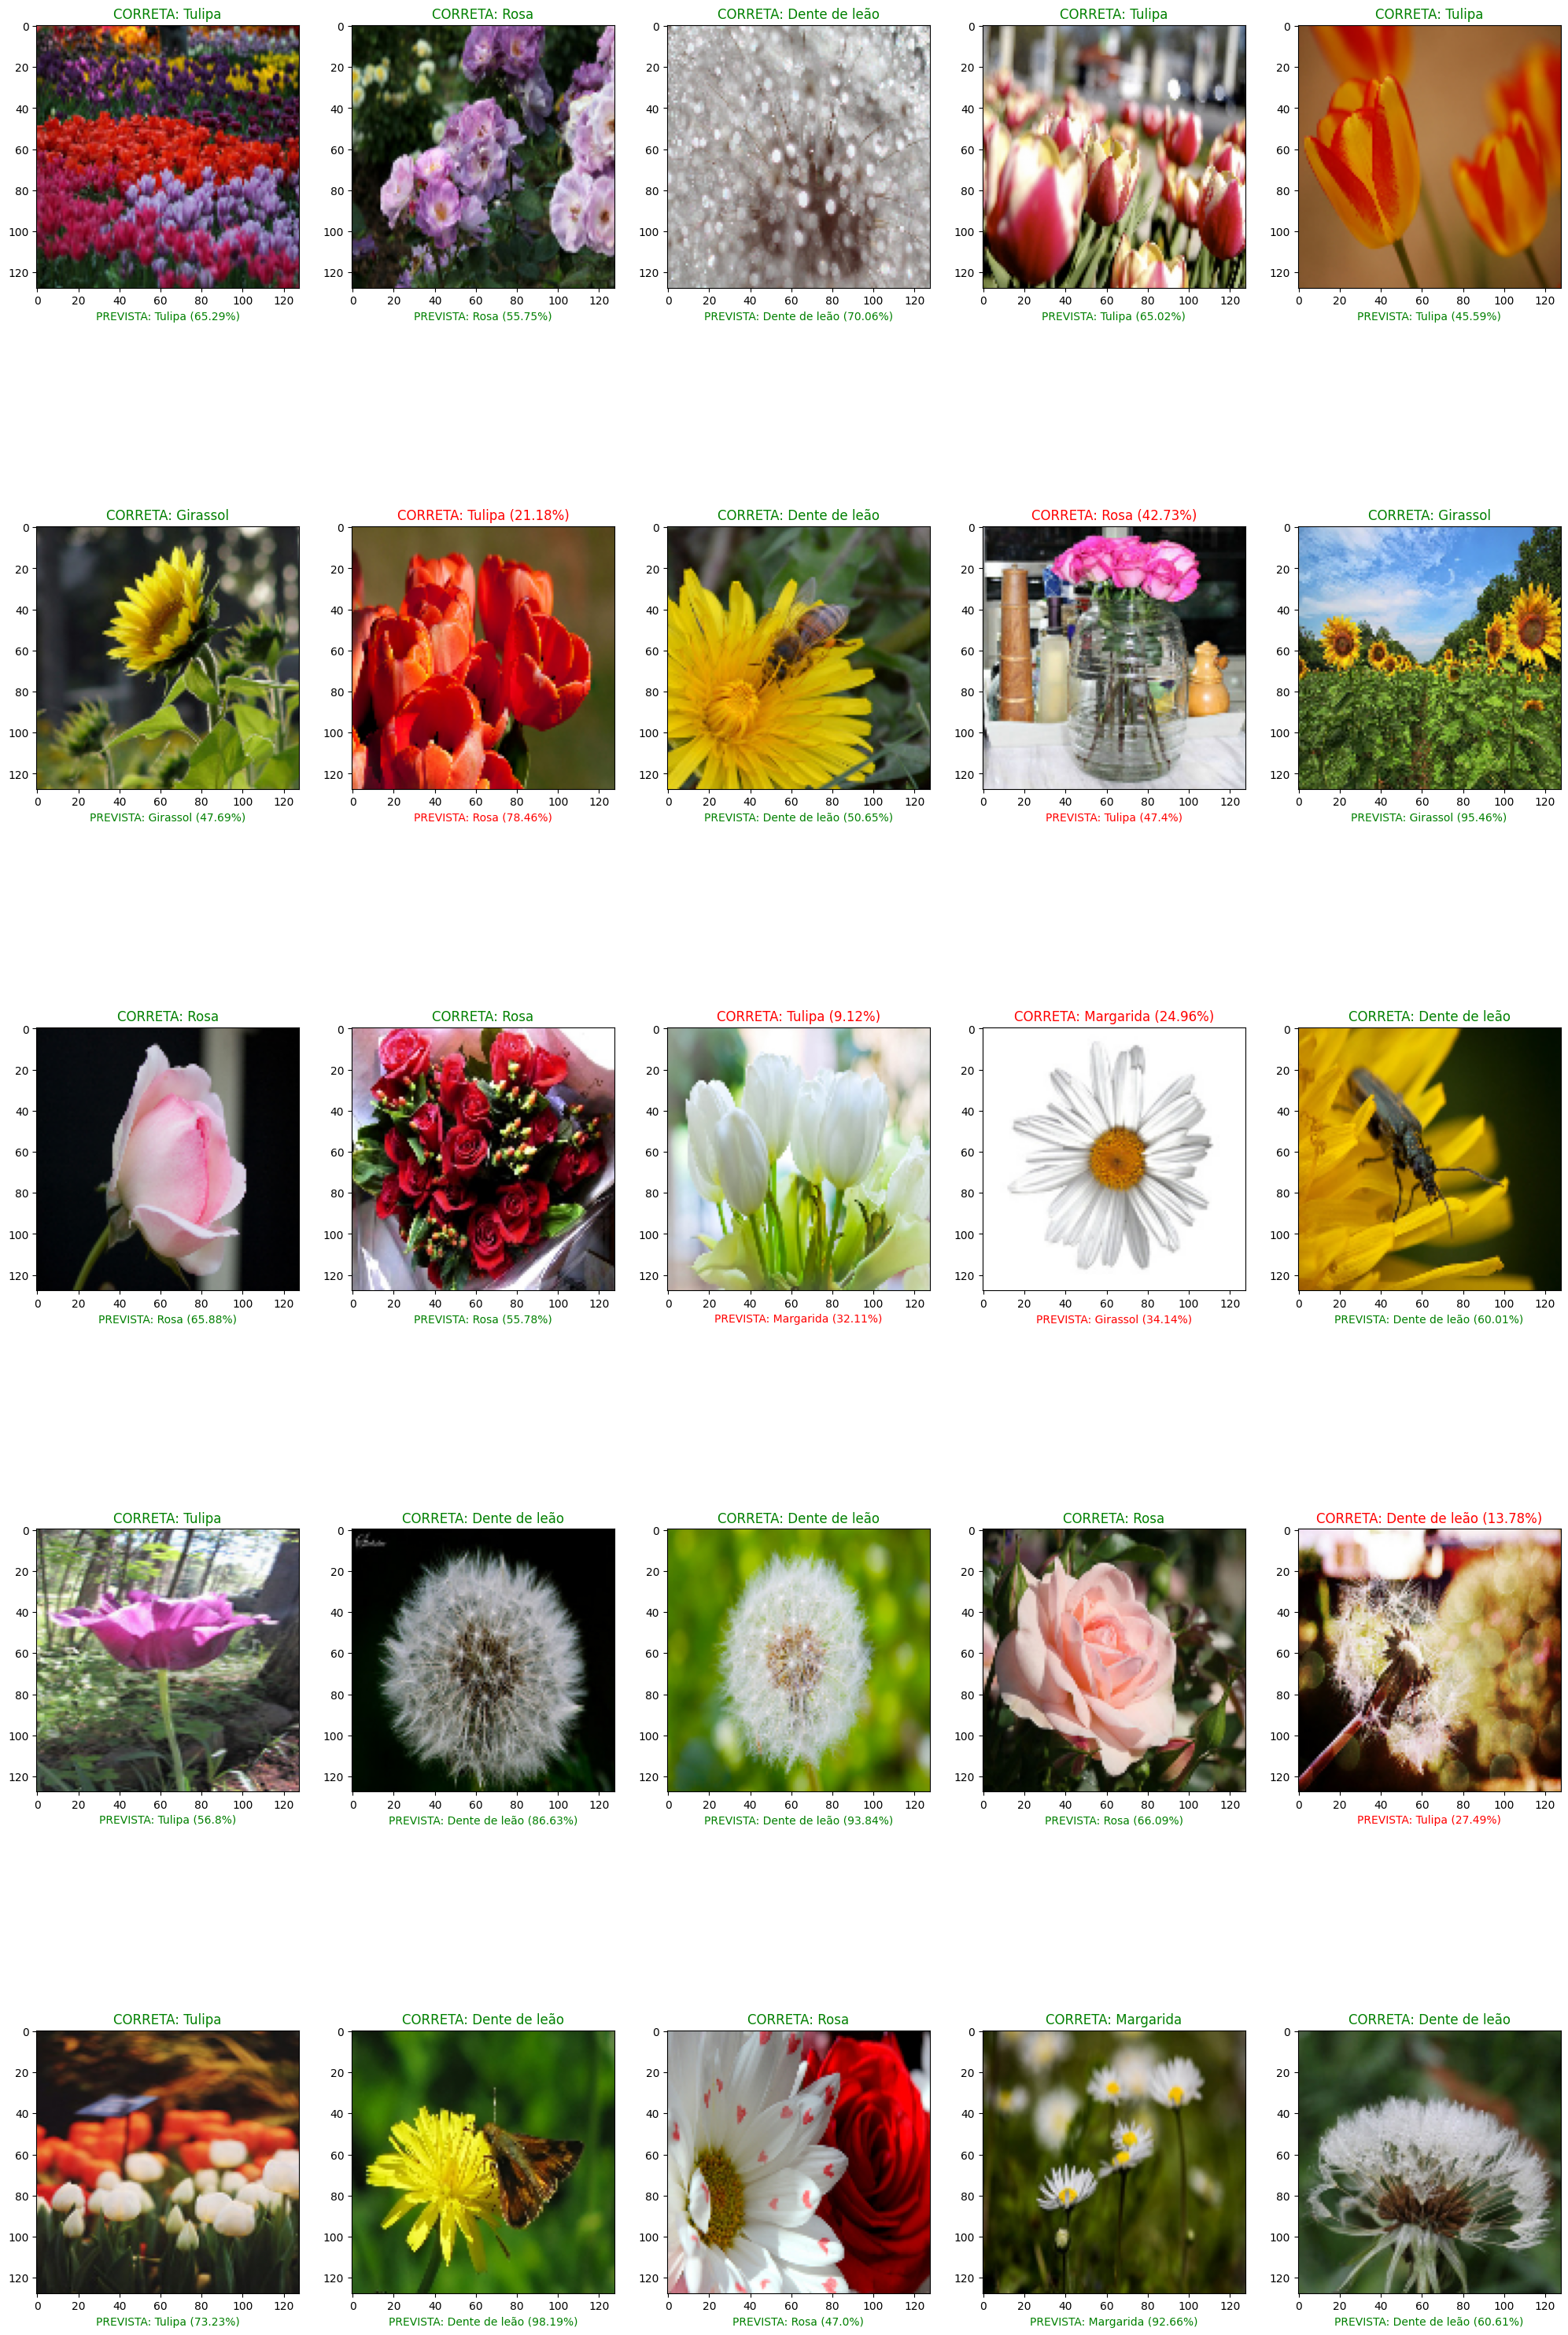

In [8]:
categorias_traduzidas = ['Margarida', 'Dente de leão', 'Rosa', 'Girassol', 'Tulipa']

test_size = 5 # tamanho da matriz de imagens a serem testadas
num_acertos = 0
num_erros = 0

categories = np.sort(os.listdir(folder_dir))
fig, ax = plt.subplots(test_size, test_size, figsize=(25, 40))

# calcula as probabilidades de todas as imagens do conjunto de teste (X_test) para cada categoria de flores [0..5] -> [daisy, dandelion, rose, sunflower, tulip]
testes = model.predict(X_test)

for i in range(test_size):
    for j in range(test_size):
        # sorteia uma imagem aleatória do conjunto de teste
        imagem_index = int(np.random.random_sample() * len(X_test))
        categoria_correta = np.argmax(y_test[imagem_index])
        # define qual a categoria de flor mais provável para a imagem a ser testada (valor entre 0 e 1)
        categoria_prevista = np.argmax(testes[imagem_index])

        is_correct = categoria_correta == categoria_prevista
        cor = 'green'  if is_correct else 'red'

        if is_correct: num_acertos += 1 
        else: num_erros += 1

        msg_prevista = "PREVISTA: " + categorias_traduzidas[categoria_prevista] + " (" + str(round(testes[imagem_index][categoria_prevista] * 100, 2)) +  "%)"
        msg_correta = "CORRETA: " + categorias_traduzidas[categoria_correta]

        if not is_correct:
            msg_correta += " (" + str(round(testes[imagem_index][categoria_correta] * 100, 2)) +  "%)"
        

        ax[i,j].set_title(msg_correta, color=cor)
        ax[i,j].set_xlabel(msg_prevista, color=cor)
        ax[i,j].imshow(np.array(X_test)[imagem_index].reshape(SIZE, SIZE, 3), cmap='gray')

taxa_acerto = (num_acertos / (test_size * test_size)) * 100

print('Número de acertos: ', num_acertos)
print('Número erros: ', num_erros)
print('Taxa de acerto: ', str(round(taxa_acerto, 2)), '%')